### Uncertainty reduction in homogenization problems, Part-2
This notebook is an extension of [Part-1](https://github.com/helalme/DataDrivenMSE/tree/master/UncertaintyReductionInHomogenization). In the previous notebook, a sequence of 5 volume elements (VE) has been considered, and all corresponding thermo-elastic properties (5 set) have been used as  traning data, afterwords, 6th and 7th  sets were predicted using LSTM network. In the current notebook, one more sequence has been considered with VE size $28.75\times 28.75\times 28.75\mu m^3$. So there are 6 components in this sequence, from which first 5 will be used for training and the 6th one will be used for validation. Then using the trained model, 7th and 8th set will be predicted with the LSTM net.

The side lenghts of the 6 cubic VEs are 28.75, 48.75, 68.75, 88.75, 108.75, 128.75 $\mu m$. The predicted properties would be at length 148.75, 168.75, 188.75 etc.

#### Importing necessary Python modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


#### Loading the data

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving RVEsize-Homogenization2.txt to RVEsize-Homogenization2.txt


#### Have a look at 6 datasets of the assumed sequence

In [4]:
#Reading Dataset, input is cubic RVE size in oneDirection, output isAveraged sigma33 for 20 time steps
dataset= np.loadtxt(io.BytesIO(uploaded['RVEsize-Homogenization2.txt'])) 

RVEsize =  dataset[0]
series= dataset[1:]
series = np.transpose(series)
series

array([[-6.80145825e+01, -9.65273204e+01, -1.17443919e+02,
        -1.33899836e+02, -1.47049385e+02, -1.57593846e+02,
        -1.66056574e+02, -1.72849980e+02, -1.78303738e+02,
        -1.82682202e+02, -1.48191922e+02, -1.13008813e+02,
        -7.72693039e+01, -4.10833140e+01, -4.53871908e+00,
         3.22937215e+01,  6.93572756e+01,  1.06606454e+02,
         1.44004583e+02,  1.81522396e+02],
       [-3.85728372e+01, -5.49696605e+01, -6.75108209e+01,
        -7.80635725e+01, -8.73350760e+01, -9.56729234e+01,
        -1.03271046e+02, -1.10247634e+02, -1.16681362e+02,
        -1.22629082e+02, -9.01058811e+01, -5.71779755e+01,
        -2.38770753e+01,  9.76832072e+00,  4.37326010e+01,
         7.79922094e+01,  1.12525554e+02,  1.47312661e+02,
         1.82335075e+02,  2.17575669e+02],
       [-3.01645182e+01, -4.24959971e+01, -5.17744379e+01,
        -5.94965060e+01, -6.62278128e+01, -7.22595870e+01,
        -7.77656075e+01, -8.28585971e+01, -8.76157425e+01,
        -9.20917255e+01, -5.8

#### Visualizing the datasets

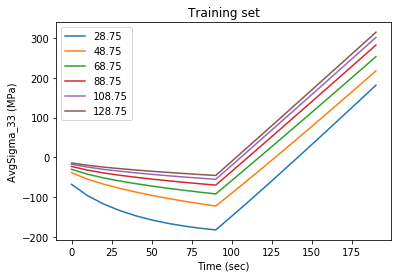

In [5]:
time=range(0,200,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

#### From the previous notebook, we have seen that 2-to-1 LSTM architecture is better than that of  1-to-1 or 3-to-1. Nevertheless, let's see how 1-to-1 architecture behaves with this 5 dataset. It is to be noted that the newly added dataset for 28.75 $\mu m$ contains high bias and variance due to lower sized VE, we took an average of 5 VE with the same size.

1-to-1 architecture means each timestep contains a single curve of 20 values.

In [173]:
Xtrain3 = series[0:4]
Ytrain3 = series[1:5]
Xtrain3=Xtrain3.reshape((Xtrain3.shape[0], 1, Xtrain3.shape[1]))
Xtrain3

array([[[ -68.01458254,  -96.5273204 , -117.4439188 , -133.8998358 ,
         -147.0493855 , -157.5938462 , -166.0565744 , -172.8499803 ,
         -178.3037382 , -182.6822024 , -148.1919219 , -113.0088128 ,
          -77.26930395,  -41.083314  ,   -4.53871908,   32.2937215 ,
           69.35727561,  106.6064539 ,  144.0045832 ,  181.5223956 ]],

       [[ -38.57283719,  -54.96966051,  -67.51082093,  -78.06357247,
          -87.33507597,  -95.67292336, -103.2710462 , -110.2476344 ,
         -116.6813624 , -122.6290818 ,  -90.10588107,  -57.17797551,
          -23.87707532,    9.76832072,   43.73260096,   77.99220944,
          112.5255538 ,  147.3126614 ,  182.3350754 ,  217.5756693 ]],

       [[ -30.16451821,  -42.49599706,  -51.77443786,  -59.49650598,
          -66.22781277,  -72.25958697,  -77.76560753,  -82.85859711,
          -87.61574247,  -92.09172553,  -58.29825131,  -24.29311689,
            9.9011628 ,   44.26712682,   78.7909101 ,  113.4613579 ,
          148.269068  ,  183

In [174]:
Xtrain3.shape

(4, 1, 20)

In [175]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

#Activation function use na korle model diverge kore, i.e activation na thaka means linear activation 
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(1, 20)),
    tf.keras.layers.LSTM(32, activation='relu'), 
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain3, Ytrain3, epochs=1000, callbacks=[callbacks])

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 3s 764ms/sample - loss: 13276.7109
Epoch 2/1000
4/4 [==============================] - 0s 3ms/sample - loss: 12522.6162
Epoch 3/1000
4/4 [==============================] - 0s 2ms/sample - loss: 11300.7109
Epoch 4/1000
4/4 [==============================] - 0s 2ms/sample - loss: 10884.3955
Epoch 5/1000
4/4 [==============================] - 0s 2ms/sample - loss: 10540.6191
Epoch 6/1000
4/4 [==============================] - 0s 2ms/sample - loss: 8613.9316
Epoch 7/1000
4/4 [==============================] - 0s 2ms/sample - loss: 6408.8408
Epoch 8/1000
4/4 [==============================] - 0s 2ms/sample - loss: 4147.8525
Epoch 9/1000
4/4 [==============================] - 0s 2ms/sample - loss: 3082.2698
Epoch 10/1000
4/4 [==============================] - 0s 2ms/sample - loss: 2069.3254
Epoch 11/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1369.9696
Epoch 12/1000
4/4 [=============================

#### Lets see the prediction at 128.75 $\mu m$ and compare with the simulated data

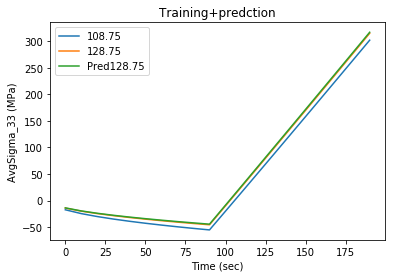

In [176]:
X4=Ytrain3[3].reshape((1, 1, 20))
pred128_75=model.predict(X4)

plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')
plt.plot(time, pred128_75[0],  label='Pred128.75')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### Prediction seems excellent, with error less than 0.7%. Lets compare individual value one by one...

In [177]:
print(series[5])
pred128_75

[-14.19592589 -20.04594669 -24.57454637 -28.44065141 -31.88423916
 -35.0242865  -37.93074036 -40.64935218 -43.21230054 -45.64335473
  -9.93606781  25.87051547  61.76482026  97.73737847 133.7802792
 169.8868897  206.0515251  242.2693029  278.5360146  314.8479048 ]


array([[-13.819354, -19.568094, -24.005486, -27.765461, -31.11943 ,
        -34.158287, -36.98076 , -39.622414, -42.09472 , -44.4803  ,
         -8.634148,  27.298372,  63.308945,  99.38307 , 135.51549 ,
        171.697   , 207.9245  , 244.19958 , 280.50082 , 316.82816 ]],
      dtype=float32)

#### Now add the predicted dataset to the sequence, retrain the same model and predict the next set at 148.75

In [192]:
Xtrain4 = np.array([series[1],series[2],series[3],series[4]])
Ytrain4 = np.array([series[2],series[3],series[4],pred128_75[0]])
Xtrain4=Xtrain4.reshape((Xtrain4.shape[0], 1, Xtrain4.shape[1]))
Xtrain4.shape

(4, 1, 20)

In [193]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

#Activation function use na korle model diverge kore, i.e activation na thaka means linear activation 
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(1, 20)),
    tf.keras.layers.LSTM(32, activation='relu'), 
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain4, Ytrain4, epochs=1200, callbacks=[callbacks])

Train on 4 samples
Epoch 1/1200
4/4 [==============================] - 2s 528ms/sample - loss: 15113.7344
Epoch 2/1200
4/4 [==============================] - 0s 2ms/sample - loss: 14496.5332
Epoch 3/1200
4/4 [==============================] - 0s 2ms/sample - loss: 13470.3105
Epoch 4/1200
4/4 [==============================] - 0s 2ms/sample - loss: 11019.8135
Epoch 5/1200
4/4 [==============================] - 0s 3ms/sample - loss: 6654.3101
Epoch 6/1200
4/4 [==============================] - 0s 3ms/sample - loss: 3928.5015
Epoch 7/1200
4/4 [==============================] - 0s 2ms/sample - loss: 3106.8218
Epoch 8/1200
4/4 [==============================] - 0s 3ms/sample - loss: 2652.2981
Epoch 9/1200
4/4 [==============================] - 0s 2ms/sample - loss: 1675.6893
Epoch 10/1200
4/4 [==============================] - 0s 3ms/sample - loss: 929.0186
Epoch 11/1200
4/4 [==============================] - 0s 2ms/sample - loss: 872.8599
Epoch 12/1200
4/4 [==============================] 

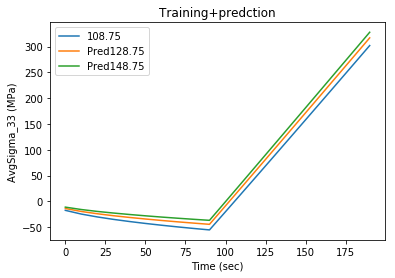

In [197]:
X5=Ytrain4[3].reshape((1, 1, 20))
pred148_75=model.predict(X5)

#X6=pred148_75.reshape((1, 1, 20))
#pred168_75=model.predict(X6)

plt.plot(time, series[4],  label='108.75')
plt.plot(time, pred128_75[0],  label='Pred128.75')
plt.plot(time, pred148_75[0],  label='Pred148.75')
#plt.plot(time, pred168_75[0],  label='Pred168.75')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

In [198]:
pred148_75

array([[-11.157766 , -15.804976 , -19.491377 , -22.597391 , -25.39902  ,
        -27.985584 , -30.397247 , -32.622883 , -34.715942 , -36.729095 ,
         -0.5359558,  35.76371  ,  72.13976  , 108.54593  , 144.9971   ,
        181.4656   , 217.99132  , 254.56685  , 291.11575  , 327.6955   ]],
      dtype=float32)

#### Lets predict the next set at 168.75 with the same procedure

In [199]:
Xtrain5 = np.array([series[1],series[2],series[3],series[4],pred128_75[0]])
Ytrain5 = np.array([series[2],series[3],series[4],pred128_75[0],pred148_75[0]])
Xtrain5=Xtrain5.reshape((Xtrain5.shape[0], 1, Xtrain5.shape[1]))
Xtrain5.shape

(5, 1, 20)

In [207]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.06) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

#Activation function use na korle model diverge kore, i.e activation na thaka means linear activation 
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(1, 20)),
    tf.keras.layers.LSTM(32, activation='relu'), 
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain5, Ytrain5, epochs=1000, callbacks=[callbacks])

Train on 5 samples
Epoch 1/1000
5/5 [==============================] - 3s 634ms/sample - loss: 15956.6641
Epoch 2/1000
5/5 [==============================] - 0s 3ms/sample - loss: 15649.8701
Epoch 3/1000
5/5 [==============================] - 0s 2ms/sample - loss: 14790.8311
Epoch 4/1000
5/5 [==============================] - 0s 1ms/sample - loss: 13506.3145
Epoch 5/1000
5/5 [==============================] - 0s 2ms/sample - loss: 12013.7812
Epoch 6/1000
5/5 [==============================] - 0s 1ms/sample - loss: 10155.3359
Epoch 7/1000
5/5 [==============================] - 0s 2ms/sample - loss: 8057.8174
Epoch 8/1000
5/5 [==============================] - 0s 2ms/sample - loss: 6101.3916
Epoch 9/1000
5/5 [==============================] - 0s 2ms/sample - loss: 4719.7822
Epoch 10/1000
5/5 [==============================] - 0s 2ms/sample - loss: 3902.8008
Epoch 11/1000
5/5 [==============================] - 0s 2ms/sample - loss: 2530.2473
Epoch 12/1000
5/5 [============================

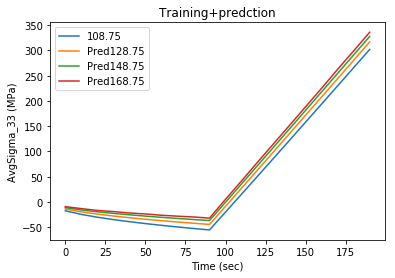

In [208]:
X6=pred148_75.reshape((1, 1, 20))
pred168_75=model.predict(X6)

plt.plot(time, series[4],  label='108.75')
plt.plot(time, pred128_75[0],  label='Pred128.75')
plt.plot(time, pred148_75[0],  label='Pred148.75')
plt.plot(time, pred168_75[0],  label='Pred168.75')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

In [209]:
pred168_75

array([[ -9.190105, -13.145012, -16.753414, -19.01697 , -21.85096 ,
        -23.727047, -26.287895, -28.111773, -29.630947, -31.991095,
          5.268061,  41.685658,  78.79073 , 115.31888 , 151.87172 ,
        188.4511  , 225.22604 , 262.68488 , 299.1519  , 335.99866 ]],
      dtype=float32)

#### Lets visualize the training set and predictions altogether

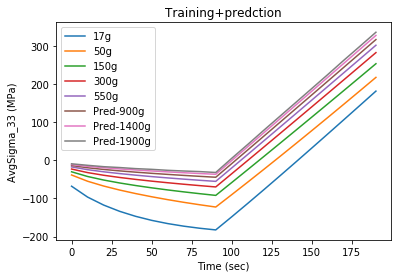

In [213]:
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, pred128_75[0],  label='Pred-128.75')
plt.plot(time, pred148_75[0],  label='Pred-148.75')
plt.plot(time, pred168_75[0],  label='Pred-168.75')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### Above curves are presented in terms of number of grains contained in the corresponding VEs, e.g. VE with length 28.75 corresponds to 17 grains, 48.75 corresponds to 50 grains, and so on, ........... 168.75 corresponds to 1900 grains.


At the end we see that the there is some percentage of relative error (maximum 2% approximately in between two last predicted sets). This menas adding a lower sized VE does not reduce the relative error.